# Mfundo Monchwe
## Advanced Machine Learning
# Gaussian Process Regression

Sometimes an unknown parameter or variable in a model is not a scalar value or a fixed-length vector, but a function. A Gaussian process (GP) can be used as a prior probability distribution whose support is over the space of continuous functions. A GP prior on the function f(x) is usually written,

$f(x) \sim \mathcal{GP}(m(x), \, k(x, x')) \,$

The function values are modeled as a draw from a multivariate normal distribution that is parameterized by the mean function, $m(x)$, and the covariance function, $k(x,x′)$. Gaussian processes are a convenient choice as priors over functions due to the marginalization and conditioning properties of the multivariate normal distribution. Usually, the marginal distribution over $f(x)$ is evaluated during the inference step. The conditional distribution is then used for predicting the function values $f(x∗)$ at new points,  
$ x∗$.

The joint distribution of $f(x)$ and $f(x∗)$ is multivariate normal,

$\begin{split}\begin{bmatrix} f(x) \\ f(x_*) \\ \end{bmatrix} \sim
\text{N}\left(
  \begin{bmatrix} m(x)  \\ m(x_*)    \\ \end{bmatrix} \,,
  \begin{bmatrix} k(x,x')    & k(x_*, x)    \\
                  k(x_*, x) &  k(x_*, x_*')  \\ \end{bmatrix}
        \right) \,.\end{split}$
${}$.
Starting from the joint distribution, one obtains the marginal distribution of f(x), as N(m(x),k(x,x′)). The conditional distribution is

In [26]:
import numpy as np
import pymc3 as pm
import arviz as az
import sklearn.gaussian_process as gp
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


 $\text{posterior} =
\frac{\text{likelihood × prior}}{\text{marginal likelihood}}$


In [2]:
x = np.atleast_2d([0, 0.1, 2, 4]).T
f =np.atleast_2d([4, 0.9, 3.6, 5])


$p(b|y, X) = 
\frac{p(y|X, b)p(b)}{p(y|X)}$



the marginal likelihood $p(y|X)$, which is independent of $b$, is calculated as

$p(y|X) = \int p(y|X, b)p(b) db$


In [3]:
x.shape, f.shape


((4, 1), (1, 4))

In [4]:

with pm.Model() as model_reg:
  #priors
  l = pm.Gamma('l', 2, 0.5)
  cov = pm.gp.cov.ExpQuad(1, ls = l)
  gp = pm.gp.Marginal(cov_func=cov)
  epsilon = pm.HalfNormal('epsilon', 25)
  #likelihood
  y_pred = gp.marginal_likelihood('y_pred', X=x ,y=f, noise = epsilon)
  trace = pm.sample(2000, tune=1000)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, l]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [5]:
with model_reg:
    marginal_post = pm.find_MAP()

In [6]:
import pandas as pd
epsilon_true = 1.0
l_true = 2.0
pd.DataFrame({'Parameters':['epsilon', 'l'],
              'value at MAP': [float(marginal_post['epsilon']), float(marginal_post['l'])],
             'True value': [epsilon_true, l_true]})

,Parameters,value at MAP,True value
0,epsilon,3.176237,1.0
1,l,2.436010,2.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffab926cb90>,
      dtype=object)

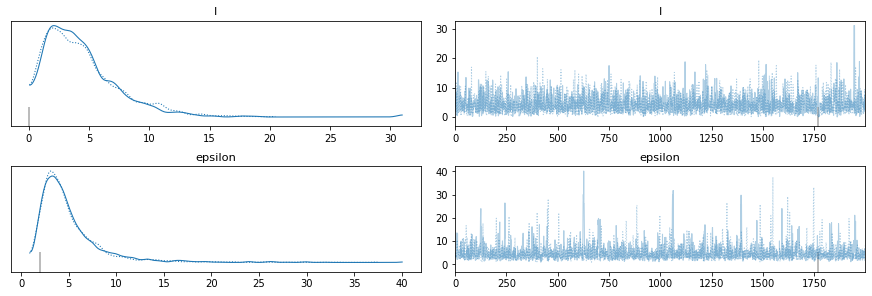

In [7]:
az.plot_trace(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa9f3fb810>,
      dtype=object)

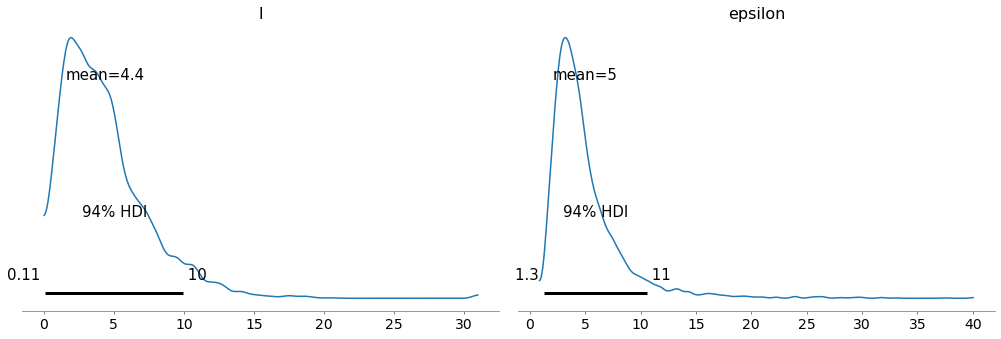

In [8]:
az.plot_posterior(trace)

In [23]:
az.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l,4.387,3.110,0.113,9.958,0.06,0.052,2256.0,1413.0,1.0
epsilon,5.009,3.481,1.272,10.559,0.09,0.068,2071.0,1749.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


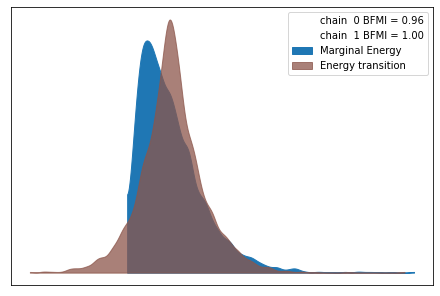

In [25]:
az.plot_energy(trace)

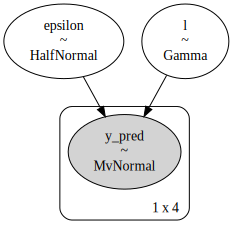

In [27]:
pm.model_to_graphviz(model_reg)

In [30]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model= model_reg)

In [9]:
#MLE
mean_eta = trace['epsilon'].mean()
mean_eta1 = trace['l'].mean()

In [10]:
i = range(0, len(trace['epsilon']),2)

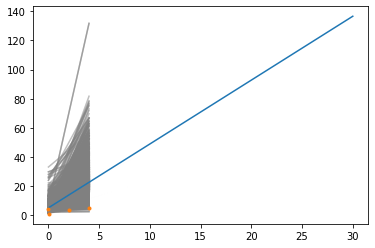

In [11]:
import matplotlib.pyplot as plt
x = np.array([0, 0.1, 2, 4])
y = np.array([4, 0.9, 3.6, 5])
plt.plot(x, trace['epsilon'][i]+trace['l'][i]*x[:,np.newaxis],
         c ='gray', alpha=0.5)
x1= np.linspace(0,30, 100)
plt.plot(x1, mean_eta+ mean_eta1*x1)
plt.plot(x,y,'.')
plt.show()

In [12]:
x = np.array([0, 0.1, 2,4])
y = np.array([4, 0.9, 3.6, 5])

In [13]:
Kx  = np.exp(-0.5*np.array([(x-xi)**2 for xi in x]))
Kx

array([[1.00000000e+00, 9.95012479e-01, 1.35335283e-01, 3.35462628e-04],
       [9.95012479e-01, 1.00000000e+00, 1.64474457e-01, 4.97955422e-04],
       [1.35335283e-01, 1.64474457e-01, 1.00000000e+00, 1.35335283e-01],
       [3.35462628e-04, 4.97955422e-04, 1.35335283e-01, 1.00000000e+00]])

In [14]:
fx = np.random.multivariate_normal(np.zeros_like(x), Kx, 10)
fx

array([[-0.93623295, -0.96278506, -0.11800962, -0.92208696],
       [ 0.36871369,  0.28642515,  0.11793635,  0.94359699],
       [ 0.14788847,  0.30107819,  0.71625427, -0.8997751 ],
       [-0.17536183, -0.27198076, -2.0123952 ,  0.26720517],
       [ 0.10394981,  0.16588352, -0.77595943,  1.53250273],
       [-2.75001872, -2.81902337, -1.71249091,  1.24571927],
       [ 0.64865472,  0.75386147,  3.33870201, -0.47574097],
       [-0.18835939, -0.10973591,  1.69136309, -0.15367836],
       [ 0.94768061,  1.05174262,  0.55604684, -1.0854612 ],
       [-1.24280296, -0.99310688,  2.42062049,  0.14766654]])

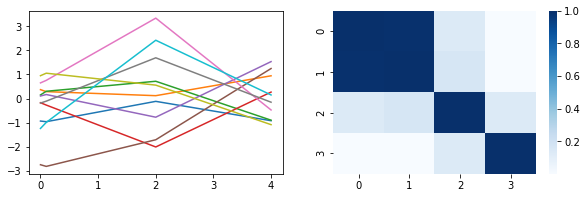

In [17]:
_,ax, = plt.subplots(1,2, figsize = (10,3))
ax[0].plot(x,fx.T)
sns.heatmap(data=Kx, cmap= 'Blues', ax=ax[1])
plt.show()

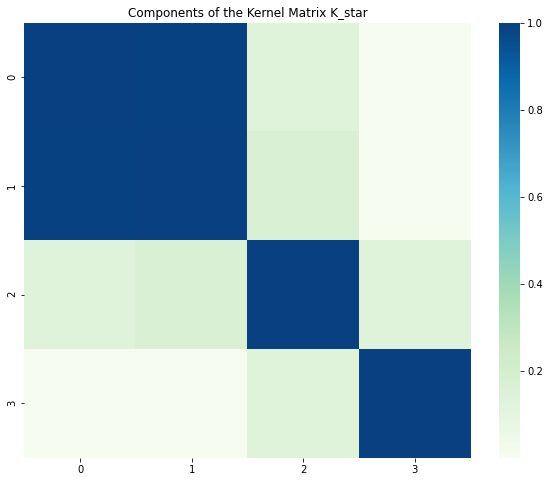

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=Kx, cmap='GnBu', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star');

Visual representation of calculating the GP posterior mean and covariance given
the example points from  Lighter colours indicate higher values. For the posterior
mean, the covariance between all observed points is multiplied by the inverse of the sum of
the covariance of the observed points and the noise matrix, as well as by the observations
of the dependent variable

example of quadratid covariance

In [19]:
X = np.linspace(0,3, 100)[:, None]
# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    with sns.axes_style("white"):

        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(K, cmap="inferno", 
                       interpolation='none', 
                       extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
        plt.colorbar(m);
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
        for i in range(samples.shape[1]):
            ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

### Covariance functions

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

PyMC3 includes a library of covariance functions to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

ref = https://colab.research.google.com/github/fonnesbeck/Bios8366/blob/master/notebooks/Section5_1-Gaussian-Processes.ipynb#scrollTo=sw1ysMTZaU1P

ValueError: ignored

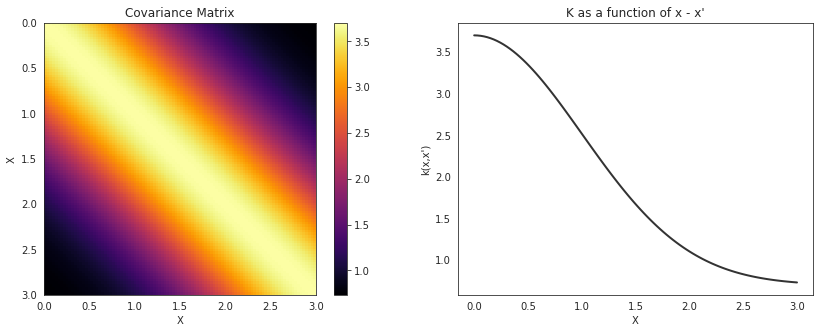

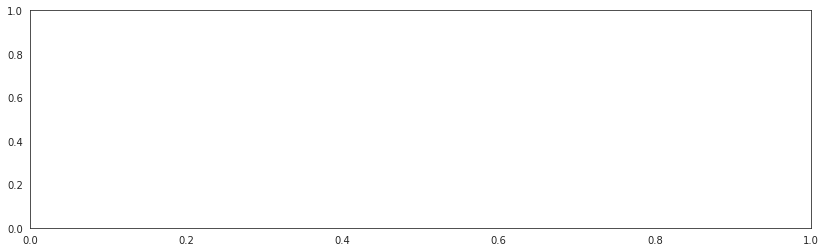

In [20]:
with pm.Model() as qmodel:
    l = 0.5
    tau = 3.0
    b = 0.7
    cov = b + tau * pm.gp.cov.ExpQuad(1,1)

K = theano.function([], cov(X))()
plot_cov(X,K)

In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [21]:
x.reshape(-1,1)


array([[0. ],
       [0.1],
       [2. ],
       [4. ]])

In [22]:
y.reshape(1,-1)

array([[4. , 0.9, 3.6, 5. ]])

In [ ]:
'
'